In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transactions = pd.read_csv("recsys_transactions.csv")
transactions.head()

,t_dat,customer_id,article_id
0,2020-09-02,7,599
1,2020-09-02,7,2600
2,2020-09-02,7,2063
3,2020-09-02,7,5188
4,2020-09-02,17,5111


## CUSTOMERS

1) First of all, we import our dataset about customers. We have the unique identifier for each customer and its age. Furthermore, we know whether he or she is subscribed to the newsletter (1 if yes, 0 if no) and if he or she is part of the special club member.

We have a look to how data are structured, printing the first five items and we get a general idea of the quantity of the data, using the shape function.

In [3]:
customers = pd.read_csv("recsys_customers.csv")
customers.head()

,customer_id,fashion_news,club_member,age
0,0,1,1,44.0
1,1,1,1,33.0
2,2,0,0,29.0
3,3,0,0,21.0
4,4,0,0,23.0


In [4]:
customers.shape

(41253, 4)

2) We want to find the columns that may have NaN values in order to handle them.

In [5]:
customers.isnull().sum()

customer_id       0
fashion_news      0
club_member       0
age             133
dtype: int64

Out of 4 columns, only 1 column has null values, which is age. 

To understand better the weight of these null values on the whole set, we can calculate their weight relative to the lenght of the dataset.

In [6]:
null_percentage= customers.isnull().sum().sort_values(ascending=False)/ len(customers)
null_percentage

age             0.003224
customer_id     0.000000
fashion_news    0.000000
club_member     0.000000
dtype: float64

The percentage of missing values is quite low, around 0.32%. 
At this point we can choose to follow 2 paths:
- Delete all the rows that contain a null value for age.
- We can fill the null cells with the most common values for age.

For the second case, we obtain the mode, which is 26, and we insert it in place of the missing values.

In [7]:
customers.age.mode()

0    26.0
Name: age, dtype: float64

In [8]:
customers['age'] = customers['age'].fillna(customers['age'].mode()[0])

3) As we want our data to be as readable and interpretable as possible, we want to convert the age type from float to integer.

In [9]:
customers["age"] = customers["age"].apply(lambda x: int(x))
customers.head()

,customer_id,fashion_news,club_member,age
0,0,1,1,44
1,1,1,1,33
2,2,0,0,29
3,3,0,0,21
4,4,0,0,23


4) A value we also want to calculate to get a better insight of our data is to divide members by 5 cathegories depending on their age. 

To simplify things, we calculate the maximum and minimum of the age values and then we create our "clusters".

In [10]:
int(max(customers["age"])) #91
int(min(customers["age"])) #16

16

What are we doing? We assign each customer to the proper age cathegory adding a column to the initial table.

In [11]:
bins = [15, 30, 45, 60, 70, 92]
groups = ['15-29', '30-44', '45-59','60-79', '80+']

customers['age_group'] = pd.cut(customers.age, bins, labels = groups, include_lowest=True)
customers

,customer_id,fashion_news,club_member,age,age_group
0,0,1,1,44,30-44
1,1,1,1,33,30-44
2,2,0,0,29,15-29
3,3,0,0,21,15-29
4,4,0,0,23,15-29
...,...,...,...,...,...
41248,41248,1,1,33,30-44
41249,41249,0,0,25,15-29
41250,41250,1,1,20,15-29
41251,41251,1,1,29,15-29


After we have cathegorized each customer, we can start to count how many members belong to each cathegory. We do this using the group by function. Obviously the total of the members in each cathegory is equal tot he length of the dataset.

In [13]:
age_group_counts = customers.groupby('age_group').size()
age_group_counts

age_group
15-29    20465
30-44     9971
45-59     9533
60-79     1111
80+        173
dtype: int64

In [13]:
#QUELLO CHE HA FATTO IL PROF --> VIENE LA STESSA COSA
#age_group_counts = Counter(customers['age_group'])
#age_group_counts

5) We are know ready to plot our age groups into a barplot to see the hetereogeneity of our dataset. In fact, as we expected, there are much more younger customers.

In [14]:
age_group_counts_df = pd.DataFrame([age_group_counts]).T.reset_index()
age_group_counts_df.columns = ['Age Group', 'Count']
age_group_counts_df

,Age Group,Count
0,15-29,20465
1,30-44,9971
2,45-59,9533
3,60-79,1111
4,80+,173


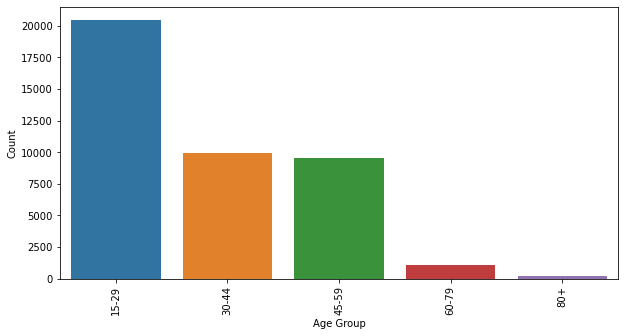

In [15]:
plt.figure(figsize=(10,5))
sns.barplot(x='Age Group', y='Count', data=age_group_counts_df)
plt.xticks(rotation=90)
plt.show()

Actually, it would be better for us also to capture how many people inside each age group have agreed to be part in the member club and how many people have activated the fashion news.

Firstly, looking at the subscription to the club member, we count how many people have agreed to it.

In [81]:
from collections import Counter

club_general = Counter(customers['club_member'])
club_general

Counter({1: 17975, 0: 23278})

In [82]:
#We create a dataframe that contains the two options (being subscribed or not being subscribed)
#and we count all the values for each of them.

In [84]:
club_general_df = pd.DataFrame([club_general]).T.reset_index()
club_general_df.columns = ['Premium Club (1=yes, 0=no)', 'Count']
club_general_df

,"Premium Club (1=yes, 0=no)",Count
0,1,17975
1,0,23278


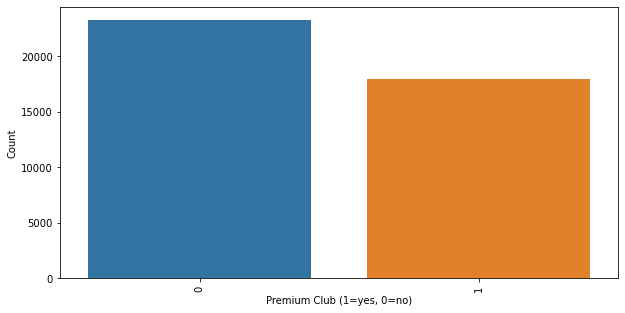

In [85]:
plt.figure(figsize=(10,5))
sns.barplot(x='Premium Club (1=yes, 0=no)', y='Count', data=club_general_df)
plt.xticks(rotation=90)
plt.show()

In [86]:
#We plot the graph of the dataframe but actually this does not tell us a lot because we
#do not know to which group age each customer belongs. 
#Therefore, we might decide to create a more accurate dataframe which always categorizes
#customers in two classes (subscribed or not subscribed) but at the same time, divides 
#the clients also by age group. In this way we can capture more information. For instance
#on average there are more people which are not subscribed to the premium club. However, most 
#of the people who are subscribed are youngsters. For what concerns elderly people, their 
#percentage of influence in the dataset is very small.

In [87]:
club_member_df = customers.groupby(['age_group', 'club_member']).count().reset_index()
club_member_df = club_member_df.drop(columns=['fashion_news', 'age'])
club_member_df.columns = ['age_group', 'club_member', 'count']
club_member_df

,age_group,club_member,count
0,15-29,0,12039
1,15-29,1,8426
2,30-44,0,5764
3,30-44,1,4207
4,45-59,0,4938
5,45-59,1,4595
6,60-79,0,469
7,60-79,1,642
8,80+,0,68
9,80+,1,105


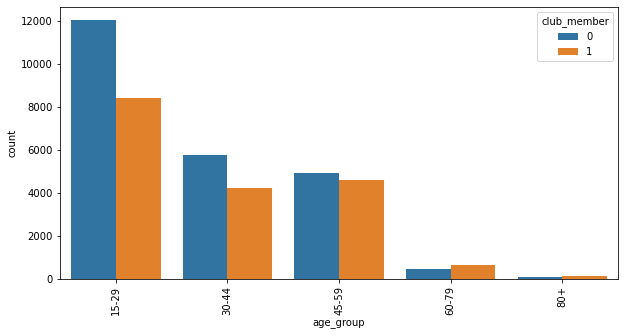

In [88]:
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='count', hue='club_member', data=club_member_df)
plt.xticks(rotation=90)
plt.show()

In [78]:
#We can do the same for the subscription to fashion news.

In [93]:
from collections import Counter
fashion_general = Counter(customers['fashion_news'])

fashion_general_df = pd.DataFrame([fashion_general]).T.reset_index()
fashion_general_df.columns = ['Fashion News (1=yes, 0=no)', 'Count']
fashion_general_df

,"Fashion News (1=yes, 0=no)",Count
0,1,18213
1,0,23040


In [95]:
fashion_news_df = customers.groupby(['age_group', 'fashion_news']).count().reset_index()
fashion_news_df = fashion_news_df.drop(columns=['club_member', 'age'])
fashion_news_df.columns = ['age_group', 'fashion_news', 'count']
fashion_news_df

,age_group,fashion_news,count
0,15-29,0,11901
1,15-29,1,8564
2,30-44,0,5710
3,30-44,1,4261
4,45-59,0,4899
5,45-59,1,4634
6,60-79,0,462
7,60-79,1,649
8,80+,0,68
9,80+,1,105


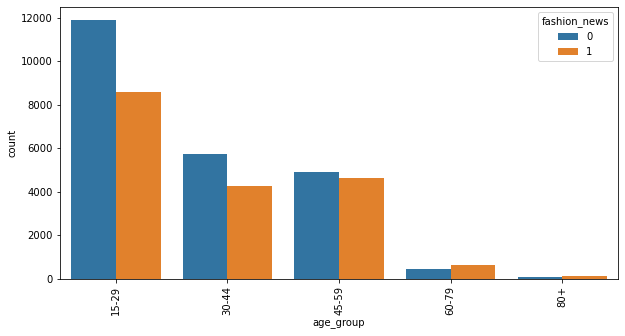

In [96]:
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='count', hue='fashion_news', data=fashion_news_df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# What can we easily capture from this graphs? People younger than 60 years old
#are much more into both subscribing to fashion news and getting in the member club.
#However, in general there are still more people which are not into these activities.